In [5]:
import jieba
from sklearn import preprocessing

def get_dataset(filepath):
    labels = []
    texts = []
    jieba.set_dictionary('dict.txt.big')
    with open(filepath, 'r', encoding = 'utf-8') as f:
        for line in f.read().splitlines():
            items = line.split('t')
            if len(items) == 2:
                labels.append(items[0])
                seg_content = ' '.join(jieba.cut(items[1], cut_all = False))
                texts.append(seg_content)
    return get_encoded_label(labels), texts


def get_encoded_label(labels):
    le = preprocessing.LabelEncoder()
    le.fit(list(set(labels)))
    return le.transform(labels)

labels, texts = get_dataset("./NLP_news_files.txt")

Building prefix dict from /Users/temping/pywork/TextClassification/dict.txt.big ...
Loading model from cache /var/folders/m8/jd1yj18n541_w6czdfyfbvt00000gn/T/jieba.u0672fdefef0eb89a60d5a573bd493141.cache
Loading model cost 1.022 seconds.
Prefix dict has been built succesfully.


In [6]:
from sklearn.model_selection import train_test_split 
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

training_text, test_text, training_label, test_label = train_test_split(texts, labels, test_size=0.1)

token = Tokenizer(num_words = 20000)
token.fit_on_texts(training_text)
vocab = token.word_index

x_train_seq = token.texts_to_sequences(training_text)
x_test_seq = token.texts_to_sequences(test_text)
x_train = sequence.pad_sequences(x_train_seq, maxlen = 150)
x_test = sequence.pad_sequences(x_test_seq, maxlen = 150)

y_train = np_utils.to_categorical(training_label)
y_test = np_utils.to_categorical(test_label)

Using TensorFlow backend.


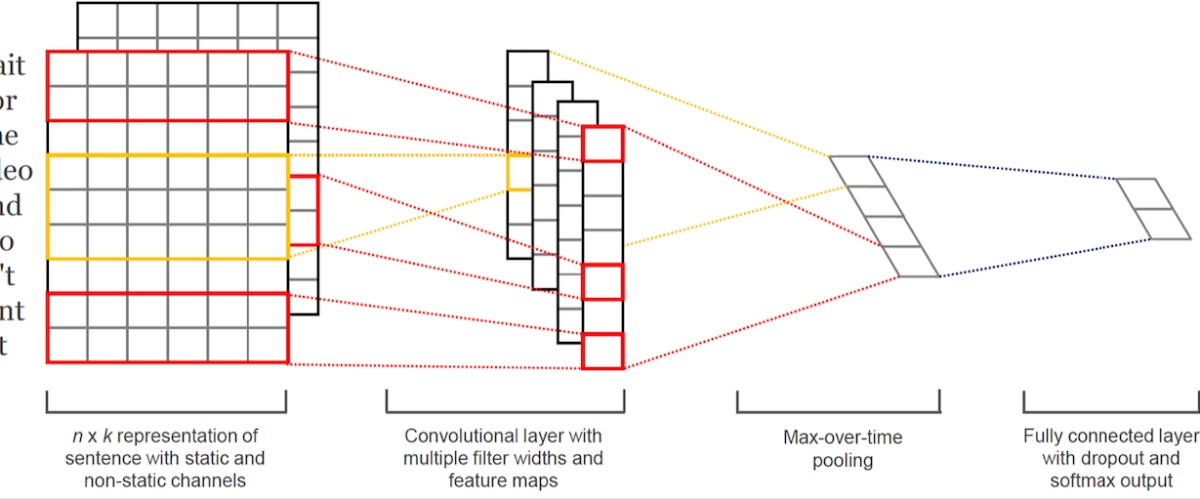

In [15]:
from IPython.core.display import Image, display
display(Image('https://pic2.zhimg.com/v2-cc89511361127dadf0f831a67a5e3b60_1200x500.jpg', width=600, unconfined=True))

In [11]:
from keras import optimizers
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding
from keras.layers import Convolution1D, Flatten, Dropout, MaxPool1D, GlobalAveragePooling1D
from keras import initializers


num_labels = 3
main_input = Input(shape=(150,), dtype='float64')
# pre-train embeddings
# embedder = Embedding(len(vocab) + 1, 300, input_length = 20, weights = [embedding_matrix], trainable = False)
# embed = embedder(main_input)

embedder = Embedding(len(vocab)+1, 300, input_length=150)
embed = embedder(main_input)

# filter size, region size
cnn = Convolution1D(2, 2, padding='same', strides = 1, activation='relu')(embed)
cnn = MaxPool1D(pool_size=4)(cnn)
flat = Flatten()(cnn)
drop = Dropout(0.2)(flat)
main_output = Dense(num_labels, activation='softmax')(drop)
model = Model(inputs = main_input, outputs = main_output)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 300)          18832800  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 2)            1202      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 2)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 74)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74)                0         
___________________________

In [12]:
optmzr = optimizers.Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer=optmzr, metrics = ['accuracy'])
train_history = model.fit(x_train, y_train, batch_size = 32, epochs = 10, verbose = 1, validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 3810 samples, validate on 424 samples
Epoch 1/10
3810/3810 [==============================] - 21s 6ms/step - loss: 0.8894 - acc: 0.5554 - val_loss: 0.5838 - val_acc: 0.7594
Epoch 2/10
3810/3810 [==============================] - 20s 5ms/step - loss: 0.3523 - acc: 0.8659 - val_loss: 0.3003 - val_acc: 0.9104
Epoch 3/10
3810/3810 [==============================] - 20s 5ms/step - loss: 0.1406 - acc: 0.9638 - val_loss: 0.2344 - val_acc: 0.9175
Epoch 4/10
3810/3810 [==============================] - 21s 5ms/step - loss: 0.0677 - acc: 0.9850 - val_loss: 0.2068 - val_acc: 0.9340
Epoch 5/10
3810/3810 [==============================] - 20s 5ms/step - loss: 0.0389 - acc: 0.9929 - val_loss: 0.2168 - val_acc: 0.9316
Epoch 6/10
3810/3810 [==============================] - 26s 7ms/step - loss: 0.0310 - acc: 0.9932 - val_loss: 0.2069 - val_acc: 0.9340
Epoch 7/10
3810/3810 [==============================] - 22s 6ms/step - loss: 0.0216 - acc: 0.99

In [13]:
pre_probability = model.predict(x_test)
predicted = pre_probability.argmax(axis=-1)

from sklearn import metrics
print("Classification report for classifier:\n%s\n"
    % ( metrics.classification_report(test_label, predicted)))

from pandas_ml import ConfusionMatrix
confusion_matrix = ConfusionMatrix(test_label, predicted)
print("Confusion matrix:\n%s" % confusion_matrix)

Classification report for classifier:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90        88
           1       0.88      0.99      0.93       189
           2       1.00      0.93      0.96       147

   micro avg       0.93      0.93      0.93       424
   macro avg       0.95      0.91      0.93       424
weighted avg       0.94      0.93      0.93       424


Confusion matrix:
Predicted   0    1    2  __all__
Actual                          
0          73   15    0       88
1           2  187    0      189
2           0   11  136      147
__all__    75  213  136      424
